## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-05-17 08:14:20--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  65.6MB/s    in 5.0s    

2021-05-17 08:14:25 (64.0 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [11]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from models import Net

device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Net().to(device)
# net.load_state_dict(torch.load('saved_models/NaimishNet.pt')) # comment if you want to train from scratch

def init_weights(layer):
    init.xavier_normal_(layer.weight, gain=init.calculate_gain('relu'))
    layer.bias.data.fill_(0.01)

# uncomment if you want to train from scratch
init_weights(net.dense1) 
init_weights(net.dense2)
init_weights(net.out)

print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (bnrm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.1)
  (bnrm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.1)
  (bnrm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.1)
  (bnrm4): BatchNorm2d(256,

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, ColorJitter, RandomFlip, RandomRotation

data_transform = transforms.Compose([ColorJitter(),
#                                      RandomFlip(),
#                                      RandomRotation(5),
                                     Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [3]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [4]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [5]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [6]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [7]:
# test the model on a batch of test images

def net_sample_output(net):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        if torch.cuda.is_available():
            images = images.type(torch.cuda.FloatTensor)
        else:
            images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [8]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output(net)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [9]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

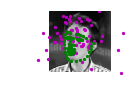

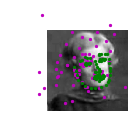

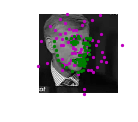

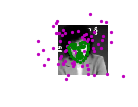

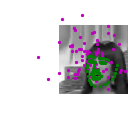

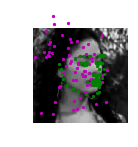

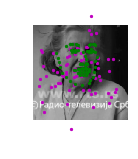

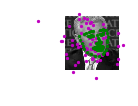

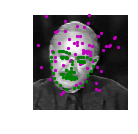

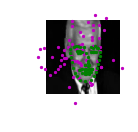

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        if image.is_cuda:
            image = image.cpu()     
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        if predicted_key_pts.is_cuda:
            predicted_key_pts = predicted_key_pts.cpu()   
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
from torch.optim import lr_scheduler

def validation_loss(net, test_loader):
    
    # prepare the net for evaluation
    was_training = net.training
    net.eval()
    with torch.no_grad():
        loss = 0.0
        running_loss = 0.0


        # validate on batches of data, assumes you already have valid_loader
        for batch_i, data in enumerate(test_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss

            if torch.cuda.is_available():
                key_pts = key_pts.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)


            if torch.cuda.is_available():
                images = images.type(torch.cuda.FloatTensor)
            else:
                images = images.type(torch.FloatTensor)

            # forward pass to get net output
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            running_loss += loss.item()

        avg_loss = running_loss/(batch_i+1)
    
    if was_training:
        net.train()
    
    return avg_loss

def train_net(net, optimizer, n_epochs, train_loader, test_loader, early_stop_criterion = 20):

    # prepare the net for training
    if not net.training:
        net.train()
    lowest_loss = 1000
    no_impr = 0
    epoch = 0
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, verbose=True)
    
    while (no_impr < early_stop_criterion) & (epoch < n_epochs):
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss

            if torch.cuda.is_available():
                key_pts = key_pts.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)


            if torch.cuda.is_available():
                images = images.type(torch.cuda.FloatTensor)
            else:
                images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            # print loss statistics

            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss/10
                
                ### EARLY STOP
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))

                running_loss = 0.0
                
        
        scheduler.step(avg_loss)
        valid_loss = validation_loss(net, test_loader)
        if valid_loss > lowest_loss:
            no_impr += 1
        else:
            lowest_loss = valid_loss
            no_impr = 0
        print(f"Epoch {epoch} is complete:\n Validation Loss is {valid_loss}, lowest Validation Loss was {lowest_loss}, last improvement was {no_impr} step(s) ago")
            
        
        epoch += 1
        
    print('Finished Training')


In [44]:
# train your network
n_epochs = 300 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(net, optimizer, n_epochs, train_loader, test_loader)

/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.5389551401138306
Epoch: 1, Batch: 20, Avg. Loss: 0.22452062219381333
Epoch: 1, Batch: 30, Avg. Loss: 0.12123826220631599
Epoch: 1, Batch: 40, Avg. Loss: 0.092021444439888
Epoch: 1, Batch: 50, Avg. Loss: 0.08437713272869587
Epoch 0 is complete:
 Validation Loss is 0.031643359788826535, lowest Validation Loss was 0.031643359788826535, last improvement was 0 step(s) ago
Epoch: 2, Batch: 10, Avg. Loss: 0.059267814829945566
Epoch: 2, Batch: 20, Avg. Loss: 0.08282760307192802


IndexError: tuple index out of range

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(net)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


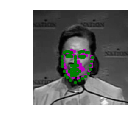

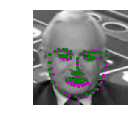

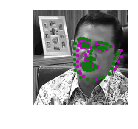

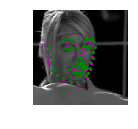

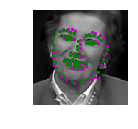

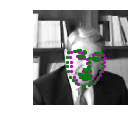

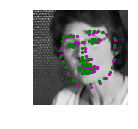

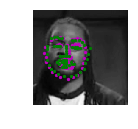

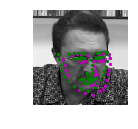

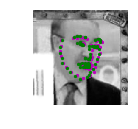

In [22]:
visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [23]:
### Uncomment and change the model name to save new model

# model_dir = 'saved_models/'
# model_name = 'NaimishNet.pt'

# # after training, save your model parameters in the dir 'saved_models'
# torch.save(net.state_dict(), model_dir+model_name)

## Transfer Learning (resnet18)  
Besides implementing the proposed model which is NaimishNet, another models were considered. Particularly, resnet18 was considered since it allows deep network to avoid the vanishing gradient descent problem.

In [32]:
from models import resnet18

# model specification
resnet = resnet18().to(device)
# resnet.load_state_dict(torch.load('saved_models/resnet.pt')) # comment if you want to train from scratch
### Uncomment if you want to train from scratch
### Notice: training the entire network provides much better results

### only train fc layer of the network
# for param in resnet.parameters():
#     param.requires_grad_(False)
# resnet.resnet18.fc = nn.Linear(32768, 136).cuda()
# params_grad = []
# for param in resnet.parameters():
#     if param.requires_grad == True:
#         params_grad.append(param)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(params_grad)

## train the entire model
init_weights(resnet.resnet18.fc)
for param in resnet.parameters():
    param.requires_grad_(True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters())

In [33]:
# training the network
n_epochs = 300 

with active_session():
    train_net(resnet, optimizer, n_epochs, train_loader, test_loader)

/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 37.384636998176575
Epoch: 1, Batch: 20, Avg. Loss: 2.0135440945625307
Epoch: 1, Batch: 30, Avg. Loss: 0.4358366668224335
Epoch: 1, Batch: 40, Avg. Loss: 0.24826884120702744
Epoch: 1, Batch: 50, Avg. Loss: 0.20160334259271623
Epoch 0 is complete:
 Validation Loss is 0.21213998417465055, lowest Validation Loss was 0.21213998417465055, last improvement was 0 step(s) ago
Epoch: 2, Batch: 10, Avg. Loss: 0.19026192426681518
Epoch: 2, Batch: 20, Avg. Loss: 0.20724078565835952
Epoch: 2, Batch: 30, Avg. Loss: 0.17887832075357438
Epoch: 2, Batch: 40, Avg. Loss: 0.202595117688179
Epoch: 2, Batch: 50, Avg. Loss: 0.189553339779377
Epoch 1 is complete:
 Validation Loss is 0.18034952681283561, lowest Validation Loss was 0.18034952681283561, last improvement was 0 step(s) ago
Epoch: 3, Batch: 10, Avg. Loss: 0.19378395825624467
Epoch: 3, Batch: 20, Avg. Loss: 0.2011684373021126
Epoch: 3, Batch: 30, Avg. Loss: 0.18653440326452256
Epoch: 3, Batch: 40, Avg. Loss: 0.17530278

Epoch: 21, Batch: 30, Avg. Loss: 0.049445627629756926
Epoch: 21, Batch: 40, Avg. Loss: 0.05150077380239963
Epoch: 21, Batch: 50, Avg. Loss: 0.05880457162857056
Epoch 20 is complete:
 Validation Loss is 0.06751355946976312, lowest Validation Loss was 0.0540167473028509, last improvement was 2 step(s) ago
Epoch: 22, Batch: 10, Avg. Loss: 0.04056633524596691
Epoch: 22, Batch: 20, Avg. Loss: 0.0664924867451191
Epoch: 22, Batch: 30, Avg. Loss: 0.04491081032902002
Epoch: 22, Batch: 40, Avg. Loss: 0.04003669992089272
Epoch: 22, Batch: 50, Avg. Loss: 0.04918768014758825
Epoch 21 is complete:
 Validation Loss is 0.042448112094888885, lowest Validation Loss was 0.042448112094888885, last improvement was 0 step(s) ago
Epoch: 23, Batch: 10, Avg. Loss: 0.05504642203450203
Epoch: 23, Batch: 20, Avg. Loss: 0.053886031918227675
Epoch: 23, Batch: 30, Avg. Loss: 0.03684711810201406
Epoch: 23, Batch: 40, Avg. Loss: 0.0343461437150836
Epoch: 23, Batch: 50, Avg. Loss: 0.03429043721407652
Epoch 22 is comple

Epoch: 41, Batch: 20, Avg. Loss: 0.018119041714817284
Epoch: 41, Batch: 30, Avg. Loss: 0.0633379272185266
Epoch: 41, Batch: 40, Avg. Loss: 0.04344064304605126
Epoch: 41, Batch: 50, Avg. Loss: 0.04291554652154446
Epoch 40 is complete:
 Validation Loss is 0.020916851218409683, lowest Validation Loss was 0.0160854502714106, last improvement was 6 step(s) ago
Epoch: 42, Batch: 10, Avg. Loss: 0.041378109529614446
Epoch: 42, Batch: 20, Avg. Loss: 0.019150081276893615
Epoch: 42, Batch: 30, Avg. Loss: 0.03830093247815967
Epoch: 42, Batch: 40, Avg. Loss: 0.016749334428459405
Epoch: 42, Batch: 50, Avg. Loss: 0.017087429016828536
Epoch 41 is complete:
 Validation Loss is 0.023425755091011524, lowest Validation Loss was 0.0160854502714106, last improvement was 7 step(s) ago
Epoch: 43, Batch: 10, Avg. Loss: 0.02319863364100456
Epoch: 43, Batch: 20, Avg. Loss: 0.0157020783983171
Epoch: 43, Batch: 30, Avg. Loss: 0.021963253058493136
Epoch: 43, Batch: 40, Avg. Loss: 0.015176908671855926
Epoch: 43, Bat

Epoch: 61, Batch: 10, Avg. Loss: 0.012985504046082497
Epoch: 61, Batch: 20, Avg. Loss: 0.01194093800149858
Epoch: 61, Batch: 30, Avg. Loss: 0.026629968779161572
Epoch: 61, Batch: 40, Avg. Loss: 0.00692208637483418
Epoch: 61, Batch: 50, Avg. Loss: 0.006796784605830908
Epoch 60 is complete:
 Validation Loss is 0.012321042538411459, lowest Validation Loss was 0.007062050447400127, last improvement was 5 step(s) ago
Epoch: 62, Batch: 10, Avg. Loss: 0.007334902696311474
Epoch: 62, Batch: 20, Avg. Loss: 0.014628254296258091
Epoch: 62, Batch: 30, Avg. Loss: 0.009616464097052812
Epoch: 62, Batch: 40, Avg. Loss: 0.009534328430891036
Epoch: 62, Batch: 50, Avg. Loss: 0.006793195940554142
Epoch 61 is complete:
 Validation Loss is 0.018415264604727224, lowest Validation Loss was 0.007062050447400127, last improvement was 6 step(s) ago
Epoch: 63, Batch: 10, Avg. Loss: 0.01198817533440888
Epoch: 63, Batch: 20, Avg. Loss: 0.006706812325865031
Epoch: 63, Batch: 30, Avg. Loss: 0.024009608337655662
Epoch

Epoch 79 is complete:
 Validation Loss is 0.007356911398736494, lowest Validation Loss was 0.0064116513774711255, last improvement was 3 step(s) ago
Epoch: 81, Batch: 10, Avg. Loss: 0.0073282391298562285
Epoch: 81, Batch: 20, Avg. Loss: 0.008406249806284904
Epoch: 81, Batch: 30, Avg. Loss: 0.005852651596069336
Epoch: 81, Batch: 40, Avg. Loss: 0.03421772965230048
Epoch: 81, Batch: 50, Avg. Loss: 0.012889428576454521
Epoch 80 is complete:
 Validation Loss is 0.006504214625349458, lowest Validation Loss was 0.0064116513774711255, last improvement was 4 step(s) ago
Epoch: 82, Batch: 10, Avg. Loss: 0.014443764090538025
Epoch: 82, Batch: 20, Avg. Loss: 0.007318552210927009
Epoch: 82, Batch: 30, Avg. Loss: 0.006057676253840327
Epoch: 82, Batch: 40, Avg. Loss: 0.009648989094421268
Epoch: 82, Batch: 50, Avg. Loss: 0.01936661605723202
Epoch 81 is complete:
 Validation Loss is 0.018639719527100727, lowest Validation Loss was 0.0064116513774711255, last improvement was 5 step(s) ago
Epoch: 83, Bat

Epoch: 100, Batch: 10, Avg. Loss: 0.008321131393313409
Epoch: 100, Batch: 20, Avg. Loss: 0.008125183172523975
Epoch: 100, Batch: 30, Avg. Loss: 0.02655932870693505
Epoch: 100, Batch: 40, Avg. Loss: 0.009642154257744551
Epoch: 100, Batch: 50, Avg. Loss: 0.006873996881768108
Epoch 99 is complete:
 Validation Loss is 0.005489092809623297, lowest Validation Loss was 0.005119540671608886, last improvement was 12 step(s) ago
Epoch: 101, Batch: 10, Avg. Loss: 0.033930972870439294
Epoch: 101, Batch: 20, Avg. Loss: 0.005387421790510416
Epoch: 101, Batch: 30, Avg. Loss: 0.005437242100015283
Epoch: 101, Batch: 40, Avg. Loss: 0.0051953298272565005
Epoch: 101, Batch: 50, Avg. Loss: 0.019180220365524293
Epoch 100 is complete:
 Validation Loss is 0.013696844737064473, lowest Validation Loss was 0.005119540671608886, last improvement was 13 step(s) ago
Epoch: 102, Batch: 10, Avg. Loss: 0.007369409315288067
Epoch: 102, Batch: 20, Avg. Loss: 0.012399214506149291
Epoch: 102, Batch: 30, Avg. Loss: 0.01085

In [34]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(resnet)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


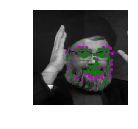

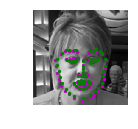

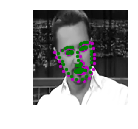

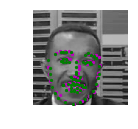

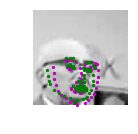

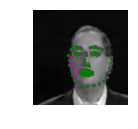

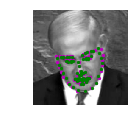

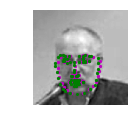

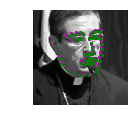

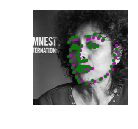

In [35]:
# output visualization

visualize_output(test_images, test_outputs, gt_pts)

In [36]:
### Uncomment and change the model name to save new model
# saving the model
model_dir = 'saved_models/'
model_name = 'resnet.pt'

# # after training, save your model parameters in the dir 'saved_models'
torch.save(resnet.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: ADAM optimizer was chosen for its adaptability and efficiency. MSELoss loss function was chosen as proposed by the article.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Firstly, the model from the proposed article was chosen. Adding batch normalization, additional linear layers (when experimenting with higher angle of rotation in transform), and trying different kernels, activation layers, and dropout probabilities did not improve the results greatly. I tried many others variants of the proposed network - both the ones I defined by myself and the ones that I found online. The best performing and the final one was found in [this](https://github.com/Bjarten/computer-vision-ND) repo by @Bjarten, who allowed to mention him in my repo (kudos to him!). However, I noticed that the model I trained has problems, particularly in cases when randomcrop works such that part of the face is not in the image, one eye is matched to the wrong eye and all the keypoints are "shifted".

Therefore, transfer learning with resnet18 was implemented which provided better results. I tried both having grad for only the last fc layer and the entire model, the latter approach worked much better. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Number of epochs was set to 300 (as proposed in the article) and early stopping mechanism was implemented with early stop after no improvement in validation loss in 20 epochs. The first model was trained semi-manually since at first early stop criteria was set to 10 which was too small and continue training increased the model fit, so I had to restart training. 
I decided not to save the parameters which perform best on test dataset, since it would slightly decrease generalization i.e. would slightly overfit the training data, as you see the validation loss "jumping" up and down across the epochs. Probably saving the model that perform best on test dataset would not hurt much (or even will be better), but regardless the final models performed well both on train and test data showing its good generalization.

batch_size was set to 64 since larger batch_size led to memory overflow problem.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.06434336  0.16439219  0.10525319 -0.15968545  0.08677734]
 [ 0.01739481  0.11619469 -0.10215528 -0.18232295 -0.18791506]
 [-0.20203993 -0.19479123 -0.16512498 -0.15818265  0.05058931]
 [-0.16570567 -0.17571525  0.03007203  0.14311843 -0.11332361]
 [-0.11455027 -0.11664765  0.10079274  0.15907569 -0.15873979]]
(5, 5)


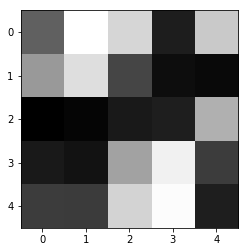

In [29]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
net.load_state_dict(torch.load('saved_models/NaimishNet.pt')) # load the weights
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


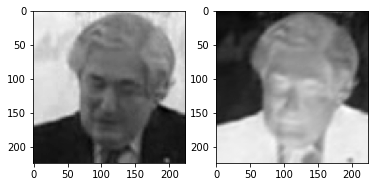

In [30]:
import cv2
img = test_dataset[0]["image"].squeeze().cpu().numpy()

kernel = w[filter_index][0]
im_filtered = cv2.filter2D(img, -1, kernel)

# plt.imshow(img)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(im_filtered, cmap="gray")
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It looks like this filter creates some kind of a negative of the image. This can be helpful for finding darker areas, for our particular tasks this may be helpful for finding mouth and eyes.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!